In [3]:
from backpack_predictor import prepare_data
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, chisquare, kruskal, ks_2samp, chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import TargetEncoder

import xgboost as xgb
from catboost import CatBoostRegressor

from optuna.integration import XGBoostPruningCallback, CatBoostPruningCallback
import optuna

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)


# X = train_df.drop(target, axis=1)
# y = train_df[target]

# Ensure categorical features are strings
# X_train.iloc[:, baseline_features] = X_train.iloc[:, baseline_features].astype(str)
# X_val.iloc[:, baseline_features]   = X_val.iloc[:, baseline_features].astype(str)

c:\Users\JBarker\AppData\Local\miniforge3\envs\kg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next test: Convert cat cols to str

In [4]:
model_str = "catboost_"
# test_name = "all_features_"
# study_name = "huber_error_"
study_name = "exclude_least_import_"
# model_str = "xgb_"
# cols_to_transform = ["weight_capacity"]

TE_features = [
    'weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color',
    'laptop_compartment', 'is_waterproof', 'size', 'material', 'style'
]
TE_new_cols = [col + "_te" for col in TE_features]
features = TE_features + TE_new_cols #+ cat_features  
# Exclude these two
features = [col for col in features if col not in ['laptop_compartment', 'is_waterproof', 'wc_decimal_count', 'style']]

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=4444)
data_splits = []

for train_index, val_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    te = TargetEncoder(target_type="continuous", smooth=20)
    train_fold[TE_new_cols] = (
        te.fit_transform(train_fold[TE_features], train_fold[target])
    )
    val_fold[TE_new_cols] = (
        te.transform(val_fold[TE_features])
    )
    data_splits.append((train_fold, val_fold))

# cat_features_fold = X_train[feature_list].select_dtypes(include=['object', 'category']).columns.tolist()
# cat_feature_indexes_fold = [X_train[feature_list].columns.get_loc(col) for col in cat_features_fold]

In [ ]:
%%time


def objective(trial):
    params = {
        "random_state": 42,
        "verbose": 0,
        "eval_metric": "RMSE",
        
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        "iterations": trial.suggest_int("iterations", 100, 5000),
        "depth": trial.suggest_int("depth", 4, 16),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 1, 50),
        
        # Additional CatBoost parameters with conditionals
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
    }

    # Conditional parameters
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)


    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 5, 1000)

    rmse_list = []

    for i, (train_fold, val_fold) in enumerate(data_splits, 1):
        model = CatBoostRegressor(**params)
        model.fit(
            train_fold[features], 
            train_fold[target],
            eval_set=[(val_fold[features], val_fold[target])],
            early_stopping_rounds=early_stopping_rounds, 
            callbacks=[CatBoostPruningCallback(trial, "RMSE")],
            use_best_model=True
        )
        preds = model.predict(val_fold[features])
        rmse = root_mean_squared_error(val_fold[target], preds)
        rmse_list.append(rmse)

    return np.mean(rmse_list)


study = optuna.create_study(
        storage=f"sqlite:///..//optuna//{model_str}db.sqlite3",
        study_name=study_name + datetime.now().strftime("%Y-%m-%d_%H-%M"),
        direction="minimize"
)
study.optimize(objective, n_trials=500)

print("\n=========================")
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.number)
print("Best value (RMSE):", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["verbose"] = 0
# best_params["eval_metric"] = "RMSE"
best_params

[I 2025-02-18 17:28:50,580] A new study created in RDB with name: exclude_least_import_2025-02-18_17-28


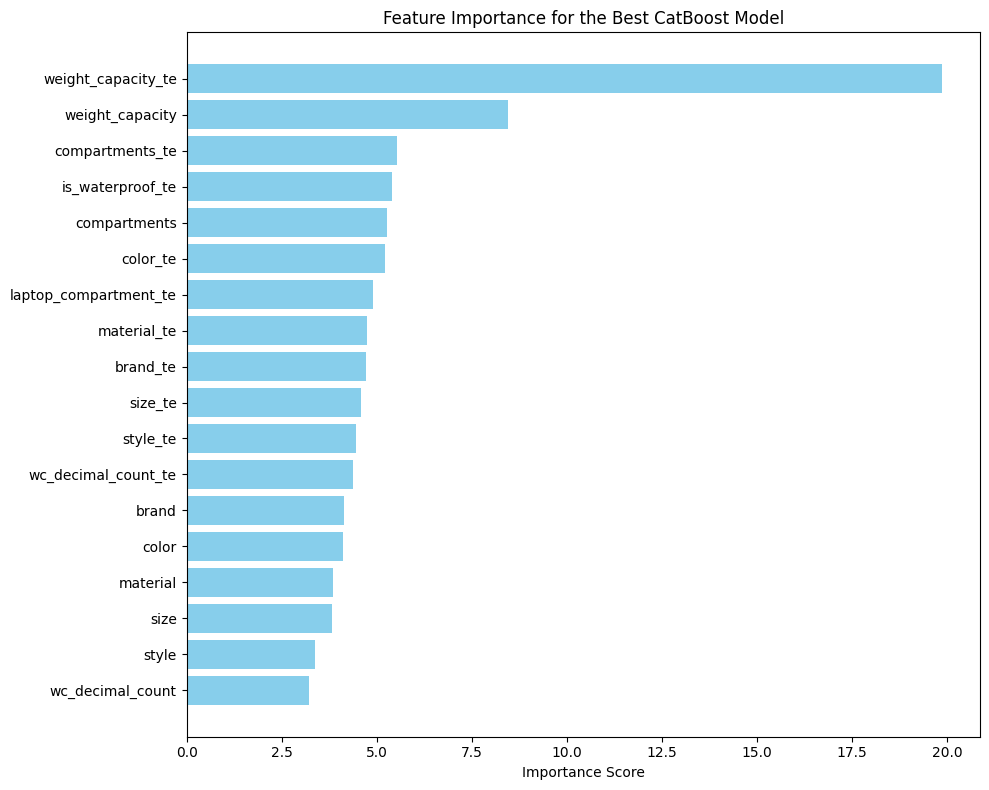

In [10]:
for i, (train_fold, val_fold) in enumerate(data_splits, 1):
    break

final_model = CatBoostRegressor(**best_params)
final_model.fit(
    train_fold[features], 
    train_fold[target], 
    # cat_features=cat_feature_indexes,  # remove or adjust if you don't have categorical features
    verbose=0
)

feature_importances = final_model.get_feature_importance()

# Create a DataFrame for easy visualization
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Plot the feature importances as a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance for the Best CatBoost Model')
plt.tight_layout()
plt.show()

In [24]:
train_fold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3195454 entries, 0 to 3994317
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   brand                  int32  
 1   material               int32  
 2   size                   int32  
 3   compartments           int32  
 4   laptop_compartment     int32  
 5   is_waterproof          int32  
 6   style                  int32  
 7   color                  int32  
 8   weight_capacity        float64
 9   price                  float64
 10  wc_decimal_count       int64  
 11  weight_capacity_te     float64
 12  compartments_te        float64
 13  wc_decimal_count_te    float64
 14  brand_te               float64
 15  color_te               float64
 16  laptop_compartment_te  float64
 17  is_waterproof_te       float64
 18  size_te                float64
 19  material_te            float64
 20  style_te               float64
dtypes: float64(12), int32(8), int64(1)
memory usage: 438.8 MB


In [22]:
feature_importances

array([ 6.58272533,  4.2668661 ,  3.41753314,  4.10408261,  3.99456259,
        2.47297798,  3.08848136,  4.08554749,  4.1098398 ,  3.18288002,
       28.40422345,  3.48873128,  2.9618188 ,  3.68252765,  4.34456307,
        3.57995982,  3.82435874,  3.73508638,  3.5371181 ,  3.13611626])

In [23]:
features

['weight_capacity',
 'compartments',
 'wc_decimal_count',
 'brand',
 'color',
 'laptop_compartment',
 'is_waterproof',
 'size',
 'material',
 'style',
 'weight_capacity_te',
 'compartments_te',
 'wc_decimal_count_te',
 'brand_te',
 'color_te',
 'laptop_compartment_te',
 'is_waterproof_te',
 'size_te',
 'material_te',
 'style_te']

In [ ]:
feature_importances = final_model.get_feature_importance()

# Create a DataFrame for easy visualization
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Plot the feature importances as a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance for the Best CatBoost Model')
plt.tight_layout()
plt.show()